## WGAN

In [ ]:
!python -m visdom.server

In [1]:
import torch
from torch import nn, optim, autograd #需要手动求导
import numpy as np
import visdom
from matplotlib import pyplot as plt
import random

parameters

In [2]:
h_dim = 400
batch_size = 8
k = 5
viz = visdom.Visdom()

Setting up a new session...


generator&discriminator

In [3]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 2),
        )
    
    def forward(self, z):
        output = self.net(z)
        return output


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 1),
        )
    
    def forward(self, x):
        output = self.net(x)
        return output.view(-1)

In [4]:
def data_generator():
    '''
    8个高斯分布混合输出
    '''
    scale = np.array([2])
    centers = [
        (1.,0.),
        (-1.,0.),
        (0.,1.),
        (0.,-1.),
        (1./np.sqrt(2), 1./np.sqrt(2)),
        (1./np.sqrt(2), -1./np.sqrt(2)),
        (-1./np.sqrt(2), 1./np.sqrt(2)),
        (-1./np.sqrt(2), -1./np.sqrt(2))
    ]
    centers = [(scale[0]*x , scale[0]*y)  for x, y in centers]

    while True:
        dataset = []
        for i in range(batch_size):
            point = np.random.randn(2) * 0.02
            center = random.choice(centers)
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        
        dataset = np.array(dataset).astype(np.float32)
        dataset /= 1.414
        yield dataset

vis (有空研究研究这玩意)

In [5]:
def generate_image(D, G, xr, epoch):
    """
    Generates and saves a plot of the true distribution, the generator, and the
    critic.
    """
    N_POINTS = 128
    RANGE = 3
    plt.clf()

    points = np.zeros((N_POINTS, N_POINTS, 2), dtype='float32')
    points[:, :, 0] = np.linspace(-RANGE, RANGE, N_POINTS)[:, None]#在指定的range内返回均匀间隔的数字。
    points[:, :, 1] = np.linspace(-RANGE, RANGE, N_POINTS)[None, :]
    points = points.reshape((-1, 2))
    # (16384, 2)
    # print('p:', points.shape)

    # draw contour
    with torch.no_grad():
        points = torch.Tensor(points).cuda() # [16384, 2]
        disc_map = D(points).cpu().numpy() # [16384]
    x = y = np.linspace(-RANGE, RANGE, N_POINTS)
    cs = plt.contour(x, y, disc_map.reshape((len(x), len(y))).transpose())
    plt.clabel(cs, inline=1, fontsize=10)
    # plt.colorbar()


    # draw samples
    with torch.no_grad():
        z = torch.randn(batch_size, 2).cuda() # [b, 2]
        samples = G(z).cpu().numpy() # [b, 2]
    plt.scatter(xr[:, 0], xr[:, 1], c='orange', marker='.')
    plt.scatter(samples[:, 0], samples[:, 1], c='green', marker='+')

    viz.matplot(plt, win='contour', opts=dict(title='p(x):%d'%epoch))

weight init

In [10]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        # m.weight.data.normal_(0.0, 0.02)
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

损失：$$L=\underset{\tilde{x}\sim \mathbb{P}_{g} }{\mathbb{E}}[D(\tilde{x})]   -\underset{x\sim \mathbb{P}_{real} }{\mathbb{E}}[D(x)]$$

-0.5728937983512878 0.09105188399553299
-697.3939208984375 476.637451171875
1325.1669921875 842.3920288085938
-7276.14990234375 -5845.109375
15469.00390625 -19461.611328125
-7893.451171875 22466.455078125
-231.7578125 10619.0078125
3180.138671875 9398.384765625
-5437.2578125 4166.884765625
4886.48095703125 71.1697998046875
-863.9033813476562 -1275.875732421875
-145293.890625 90502.2578125
-81192.1640625 5679.20751953125
-745224.5625 953590.875
-52852.9921875 70588.296875
-17136.62890625 -13253.9580078125
-16116.482421875 15753.2705078125
14254.548828125 1562.97021484375
14093.69140625 -37123.9921875
1074.2642822265625 -1666.090576171875
-32169.84375 -7235.52734375
-3035.984375 -92257.9921875
57019.9375 -99431.1875
-34226.47265625 98791.0390625
64602.4296875 -149661.8125
-33384.33984375 1279.821044921875
-22857.27734375 -132.78271484375
-8343.14453125 1341.8868408203125
-84658.328125 81307.5703125
-216507.015625 -40343.26171875
466148.8125 -499326.0625
32824.36328125 50959.37890625
-154

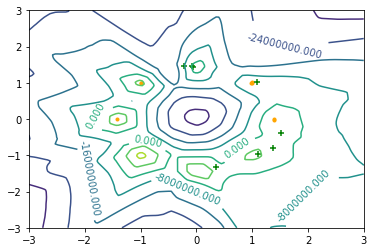

In [12]:
torch.manual_seed(23)
np.random.seed(23)

data_iter = data_generator()
x = next(data_iter)

G = Generator().to("cuda")
D = Discriminator().to("cuda")
optim_G = optim.Adam(G.parameters(), lr=5e-4, betas=(0.5,0.9))
optim_D = optim.Adam(D.parameters(), lr=5e-4, betas=(0.5,0.9))

viz.line([[0,0]], [0], win='loss', opts=dict(title='loss',
                                                legend=['D', 'G']))

for epoch in range(10000):
    '''
    交替训练DG
    '''
    for i in range(k):
        '''训D'''
        # 用真实标签训练discriminator,输出越大越好
        real = next(data_iter)
        real = torch.from_numpy(real).to("cuda")
        predict_real = D(real)
        loss_real = -predict_real.mean()

        # 生成假数据训练discriminator
        fake = torch.randn(batch_size,2).to("cuda")
        fake = G(fake).detach() # 冻结生成器梯度
        predict_fake = D(fake)
        loss_fake = predict_fake.mean()

        # 优化discriminator
        optim_D.zero_grad()
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optim_D.step()


    '''训G'''
    fake = torch.randn(batch_size,2).to("cuda")
    fake = G(fake)
    predict_fake = D(fake)
    loss_G = -predict_fake.mean()

    # 优化Generator
    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()
        
    if epoch % 100 == 0:
        viz.line([[loss_D.item(), loss_G.item()]], [epoch], win='loss', update='append')
        generate_image(D, G, real.cpu(), epoch)
        print(loss_D.item(),loss_G.item())

## WGAN-GP 带有惩罚项的改进版本

惩罚项为:
$$Penalty =\lambda\underset{\hat{x} \sim \mathbb{P}_{\hat{x}} }{\mathbb{E}}[(\left \| \nabla_{\hat{x}}D(\hat{x} )  \right \|_{2}-1 )^2] $$
其中，xhat为给定一个输入，在generator和真实分布下的输出的线性插值
$$\hat{x}=t\hat{x}+(1-t)x \quad with 0\le t\le 1$$

In [20]:
'''梯度惩罚项'''
def gradient_penalty(D, real, fake):
    LAMBDA = 0.3

    # only constrait for Discriminator
    fake = fake.detach() # 避免无关梯度计算
    real = real.detach()

    #   随机生成差值系数
    # [b, 1] => [b, 2]
    coeff = torch.rand(batch_size , 1).cuda()# 均匀分布
    coeff = coeff.expand_as(real)            # [b, 1] => [b, 2]

    interpolates = coeff * real + ((1 - coeff) * fake)
    interpolates.requires_grad_() # 要求对其(xhat)求导

    disc_interpolates = D(interpolates)

    #   求D(xhat) 对 xhat 的导数
    #   create_graph:   略
    #   retain_graph:   autograd和backward执行后都会销毁前向计算图，而惩罚项在整个损失函数
    #                   backward之间计算，为了保留xhat之前的计算图对权重参数求导优化，
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones_like(disc_interpolates),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    # 求（对x）梯度二范数与1 的差，理想状态下会接近于1
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA

    return gp

In [13]:
torch.manual_seed(23)
np.random.seed(23)

data_iter = data_generator()
x = next(data_iter)

G = Generator().to("cuda")
D = Discriminator().to("cuda")
optim_G = optim.Adam(G.parameters(), lr=5e-4, betas=(0.5,0.9))
optim_D = optim.Adam(D.parameters(), lr=5e-4, betas=(0.5,0.9))

viz.line([[0,0]], [0], win='loss', opts=dict(title='loss',
                                                legend=['D', 'G']))

for epoch in range(10000):
    '''
    交替训练DG
    '''
    for i in range(k):
        '''训D'''
        # 用真实标签训练discriminator,输出越大越好
        real = next(data_iter)
        real = torch.from_numpy(real).to("cuda")
        predict_real = D(real)
        loss_real = -predict_real.mean()

        # 生成假数据训练discriminator
        fake = torch.randn(batch_size,2).to("cuda")
        fake = G(fake).detach() # 冻结生成器梯度
        predict_fake = D(fake)
        loss_fake = predict_fake.mean()

        # 优化discriminator
        optim_D.zero_grad()
        loss_D = loss_real + loss_fake + gradient_penalty(D,real,fake.detach())# 由于fake是G生成的
        loss_D.backward()
        optim_D.step()


    '''训G'''
    fake = torch.randn(batch_size,2).to("cuda")
    fake = G(fake)
    predict_fake = D(fake)
    loss_G = -predict_fake.mean()

    # 优化Generator
    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()
        
    if epoch % 100 == 0:
        viz.line([[loss_D.item(), loss_G.item()]], [epoch], win='loss', update='append')
        generate_image(D, G, real.cpu(), epoch)
        print(loss_D.item(),loss_G.item())